# Web Scraping 

In [1]:
# import libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

We'll create 2 datasets: one - containing ratings that reviewers gave (values from the tables on the website), and another - containing only text reviews. For the 1st dataset we'll perform EDA and for the 2nd - Sentiment Analysis

In [2]:
columns = ['Date Flown','Aircraft','Type Of Traveller','Seat Type','Seat Comfort','Cabin Staff Service','Food & Beverages',
               'Inflight Entertainment','Ground Service','Value For Money','Wifi & Connectivity','Recommended']
# create 2 dataframes
df = pd.DataFrame(columns=columns)
df2 = pd.DataFrame(columns=['Text'])

temp_row1 = 0
temp_row2 = 0

# web scraping and adding values to our new dataframe
for i in range(1, math.ceil(3423/100)+1):
    URL = f'https://www.airlinequality.com/airline-reviews/british-airways/page/{i}/?sortby=post_date%3ADesc&pagesize=100'

    page = requests.get(URL)

    soup = BeautifulSoup(page.content, 'html.parser')

    reviews = soup.find_all('div', class_ = 'body')

    for review in reviews:
        table = review.find('table')
        fields = table.find_all('tr')
        for field in fields:
            attribute = field.find_all('td')[0].text
            value = field.find_all('td')[1].text
            rating = len(field.find_all('td')[1].find_all('span', class_ = "star fill"))
            if attribute in columns:
                if rating == 0:
                    df.loc[temp_row1, attribute] = value
                else:
                    df.loc[temp_row1, attribute] = rating
        temp_row1 += 1
    
    texts = soup.find_all('div', class_ = 'text_content')
    
    for text in texts:
        text = text.text[15:]        # without 'Trip Verified'/ 'Not Verified'
        df2.loc[temp_row2,'Text'] = text            # add value to dataframe
        temp_row2 += 1

# Quick EDA

In [3]:
df1 = df.copy()

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3432 entries, 0 to 3431
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Date Flown              2654 non-null   object
 1   Aircraft                1793 non-null   object
 2   Type Of Traveller       2662 non-null   object
 3   Seat Type               3430 non-null   object
 4   Seat Comfort            3334 non-null   object
 5   Cabin Staff Service     3326 non-null   object
 6   Food & Beverages        3101 non-null   object
 7   Inflight Entertainment  2416 non-null   object
 8   Ground Service          2596 non-null   object
 9   Value For Money         3432 non-null   object
 10  Wifi & Connectivity     507 non-null    object
 11  Recommended             3432 non-null   object
dtypes: object(12)
memory usage: 477.6+ KB


In [5]:
df1.head()

,Date Flown,Aircraft,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Wifi & Connectivity,Recommended
0,December 2022,A320,Business,Business Class,5,5,3,3,5,3,3,no
1,December 2022,Boeing 777,Couple Leisure,Premium Economy,3,4,3,NaN,3,3,NaN,yes
2,November 2022,A320,Solo Leisure,Business Class,2,1,1,NaN,2,1,NaN,no
3,December 2022,NaN,Business,Business Class,1,NaN,NaN,NaN,2,3,NaN,no
4,December 2022,NaN,Family Leisure,Economy Class,3,2,1,NaN,3,2,NaN,no


In [6]:
# fill missing values in columns containing ratings (4:10) with corresponding median value 
for col in df1.iloc[:, 4:11].columns:
    df1[col].replace('N/A', np.nan, inplace=True)
    df1[col] = df1[col].astype('Int64').fillna(df1[col].median())
    
df1['Recommended'].replace(['yes', 'no'], [1, 0], inplace = True)                    # yes/no --> 1/0

In [7]:
# drop unnecessary features 
df1 = df1.iloc[:, 3:]
df1.head()

,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Wifi & Connectivity,Recommended
0,Business Class,5,5,3,3,5,3,3,0
1,Premium Economy,3,4,3,3,3,3,1,1
2,Business Class,2,1,1,3,2,1,1,0
3,Business Class,1,4,3,3,2,3,1,0
4,Economy Class,3,2,1,3,3,2,1,0


In [8]:
# pivot table with ratings' median values estimated for each Seat Type
ratings_by_SeatType = df1.groupby(["Seat Type"]).median().astype(int)
ratings_by_SeatType

,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Wifi & Connectivity,Recommended
Seat Type,,,,,,,,
Business Class,3,4,3,3,3,3,1,0
Economy Class,3,3,3,3,3,3,1,0
First Class,4,4,3,3,3,3,1,0
Premium Economy,3,3,3,3,3,3,1,0


In [9]:
# ratings' median values
avr = df1.median().astype(int)
avr

C:\Users\User\AppData\Local\Temp/ipykernel_4928/2034191930.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avr = df1.median().astype(int)


Seat Comfort              3
Cabin Staff Service       4
Food & Beverages          3
Inflight Entertainment    3
Ground Service            3
Value For Money           3
Wifi & Connectivity       1
Recommended               0
dtype: int32

In [10]:
df1[df1['Seat Type'] == 'Premium Economy'].Recommended.value_counts()

0    195
1    143
Name: Recommended, dtype: int64

In [11]:
df.to_csv('raw_BritishAirwaysReviews.csv', na_rep='NaN', sep = ',')
df1.to_csv('pretty_BritishAirwayReviews.csv', na_rep='NaN', sep=',')
df2.to_csv('textReviews.csv', na_rep='NaN', sep=',')

In [12]:
#df1 = pd.read_csv('pretty_BritishAirwayReviews.csv')

# Sentiment Analysis

In [13]:
df2.head()

,Text
0,| Glasgow to London delayed by 1 hour. My wi...
1,"| When I tried to check in online, I was off..."
2,| I flew from Prague to LHR. Excellent servi...
3,| Disappointing again especially on business...
4,| During both the outbound and return flight...


In [14]:
df2 = df2.reset_index()
df2.head()

,index,Text
0,0,| Glasgow to London delayed by 1 hour. My wi...
1,1,"| When I tried to check in online, I was off..."
2,2,| I flew from Prague to LHR. Excellent servi...
3,3,| Disappointing again especially on business...
4,4,| During both the outbound and return flight...


## Basic NLTK

In [15]:
## Basic NLTK
import nltk
#nltk.download('punkt')
#nltk.download("book")
#nltk.download('vader_lexicon') 

Let's see how it works on a single example

In [17]:
example = df2['Text'][50]                 
example

' |  Manchester to Seattle via London. I will never fly BA again. They cancelled my return flight from Heathrow back to Manchester and then cancelled the alternative offered. We had to get our son come all the way to London to pick us up and take us to our car in Manchester. The food was terrible and on the return journey as soon as they had finished serving they were round taking our trays so that they could settle down for the night. I will not be flying BA again'

In [18]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['|',
 'Manchester',
 'to',
 'Seattle',
 'via',
 'London',
 '.',
 'I',
 'will',
 'never']

In [19]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('|', 'RB'),
 ('Manchester', 'NNP'),
 ('to', 'TO'),
 ('Seattle', 'NNP'),
 ('via', 'IN'),
 ('London', 'NNP'),
 ('.', '.'),
 ('I', 'PRP'),
 ('will', 'MD'),
 ('never', 'RB')]

In [20]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  |/RB
  Manchester/NNP
  to/TO
  (GPE Seattle/NNP)
  via/IN
  (GPE London/NNP)
  ./.
  I/PRP
  will/MD
  never/RB
  fly/VB
  BA/NNP
  again/RB
  ./.
  They/PRP
  cancelled/VBD
  my/PRP$
  return/NN
  flight/NN
  from/IN
  (GPE Heathrow/NNP)
  back/RB
  to/TO
  Manchester/NNP
  and/CC
  then/RB
  cancelled/VBD
  the/DT
  alternative/NN
  offered/VBN
  ./.
  We/PRP
  had/VBD
  to/TO
  get/VB
  our/PRP$
  son/NN
  come/VB
  all/PDT
  the/DT
  way/NN
  to/TO
  (GPE London/NNP)
  to/TO
  pick/VB
  us/PRP
  up/RP
  and/CC
  take/VB
  us/PRP
  to/TO
  our/PRP$
  car/NN
  in/IN
  Manchester/NNP
  ./.
  The/DT
  food/NN
  was/VBD
  terrible/JJ
  and/CC
  on/IN
  the/DT
  return/NN
  journey/NN
  as/RB
  soon/RB
  as/IN
  they/PRP
  had/VBD
  finished/VBN
  serving/VBG
  they/PRP
  were/VBD
  round/VBN
  taking/VBG
  our/PRP$
  trays/NNS
  so/RB
  that/IN
  they/PRP
  could/MD
  settle/VB
  down/RP
  for/IN
  the/DT
  night/NN
  ./.
  I/PRP
  will/MD
  not/RB
  be/VB
  flying/VBG
  BA/NNP
  

## Vader Sentiment Scoring
VADER (Valence Aware Dictionary and sEntiment Reasoner).
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.
This uses a "bag of words" approach:
1. Stop words are removed
2. each word is scored and combined to a total score.

In [21]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [22]:
sia = SentimentIntensityAnalyzer()

In [23]:
# let's see how it works
print(sia.polarity_scores('This is the worst thing ever.'))
print(sia.polarity_scores(example))

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}
{'neg': 0.078, 'neu': 0.922, 'pos': 0.0, 'compound': -0.7269}


In [24]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df2.iterrows(), total=len(df2)):
    text = row['Text']
    res[i] = sia.polarity_scores(text)

  0%|          | 0/3432 [00:00<?, ?it/s]

In [25]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().merge(df2, how='left')
vaders.head()

,index,neg,neu,pos,compound,Text
0,0,0.181,0.734,0.085,-0.5984,| Glasgow to London delayed by 1 hour. My wi...
1,1,0.021,0.828,0.151,0.9867,"| When I tried to check in online, I was off..."
2,2,0.078,0.849,0.073,0.2669,| I flew from Prague to LHR. Excellent servi...
3,3,0.297,0.703,0.000,-0.8999,| Disappointing again especially on business...
4,4,0.058,0.942,0.000,-0.5423,| During both the outbound and return flight...


## Roberta Pretrained Model
- A model trained on a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [26]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [27]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [28]:
# Run Roberta Model on an example
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

{'roberta_neg': 0.9509136, 'roberta_neu': 0.04329962, 'roberta_pos': 0.005786689}


In [29]:
# Compare Vader and Roberta results
print(sia.polarity_scores(example))
print(scores_dict)

{'neg': 0.078, 'neu': 0.922, 'pos': 0.0, 'compound': -0.7269}
{'roberta_neg': 0.9509136, 'roberta_neu': 0.04329962, 'roberta_pos': 0.005786689}


In [30]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict   

In [35]:
# Combine Vader and Roberta results of the 1st 100 reviews (due to computer's capacity)
res = {}
for i, row in tqdm(df2[:100].iterrows(), total = 100):
    try:
        text = row['Text']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[i] = both
    except RuntimeError:
        print(f"Broke for id {i}")

  0%|          | 0/100 [00:00<?, ?it/s]

Broke for id 67
Broke for id 87


In [40]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().merge(df2, how='left')
results_df

,index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Text
0,0,0.181,0.734,0.085,-0.5984,0.454877,0.440995,0.104129,| Glasgow to London delayed by 1 hour. My wi...
1,1,0.021,0.828,0.151,0.9867,0.031609,0.171954,0.796437,"| When I tried to check in online, I was off..."
2,2,0.078,0.849,0.073,0.2669,0.739790,0.203867,0.056342,| I flew from Prague to LHR. Excellent servi...
3,3,0.297,0.703,0.000,-0.8999,0.926351,0.064960,0.008689,| Disappointing again especially on business...
4,4,0.058,0.942,0.000,-0.5423,0.948756,0.046086,0.005158,| During both the outbound and return flight...
...,...,...,...,...,...,...,...,...,...
93,95,0.093,0.856,0.052,-0.6844,0.656587,0.268512,0.074901,| The A80 is a wonderful aircraft - quieter ...
94,96,0.131,0.742,0.127,-0.0800,0.104892,0.378724,0.516383,| LHR to SFO in new Club Suite. Rather chaot...
95,97,0.114,0.826,0.059,-0.5983,0.941323,0.052358,0.006319,| Covid form is broken - Called customer serv...
96,98,0.070,0.766,0.163,0.9891,0.345992,0.409268,0.244740,Feels like BA are putting the 'economy' back ...


## Compare Vader and Roberta Results

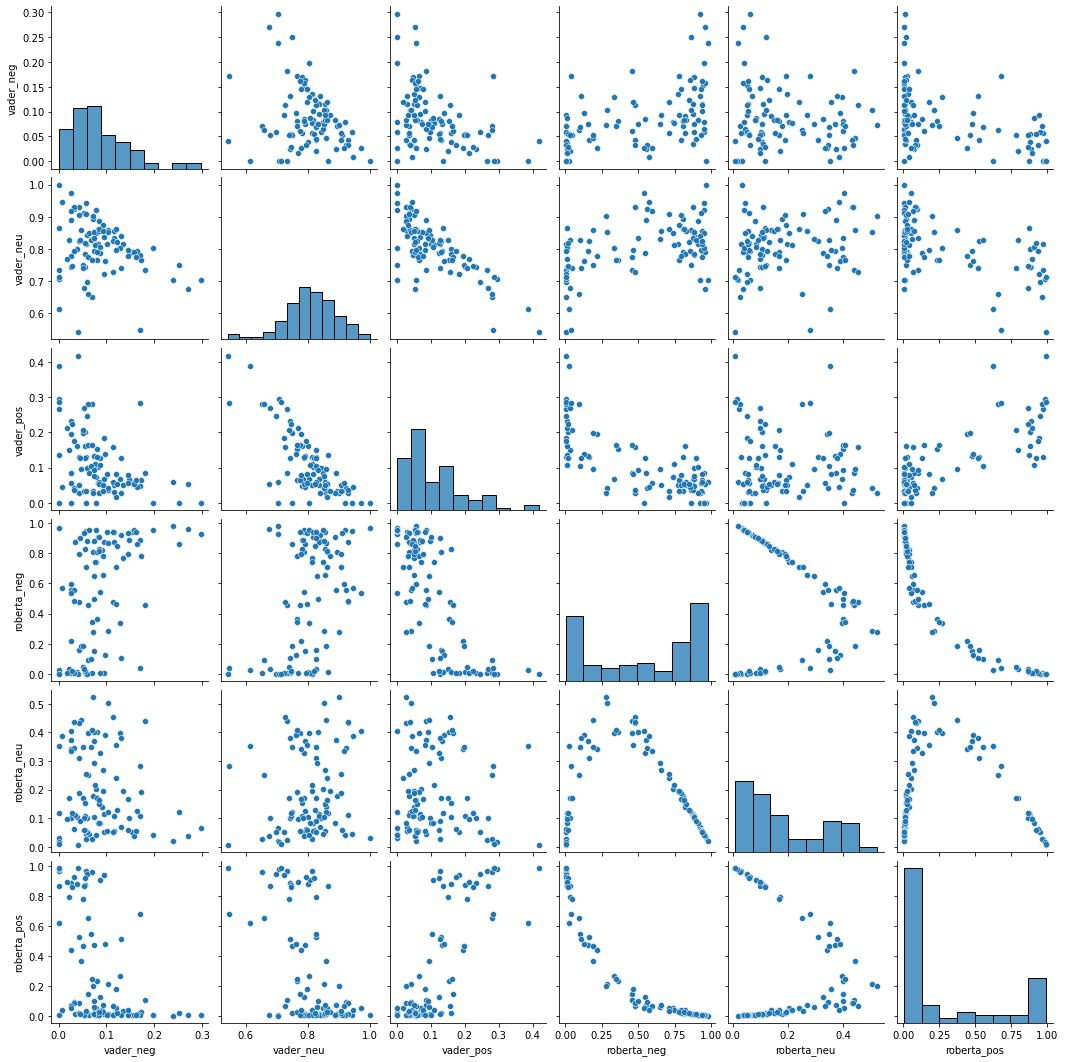

In [41]:
import seaborn as sns
sns.pairplot(data=results_df, 
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
             palette='tab10')
plt.show()

As we can see there are some sort of correlation between Vader and Roberta results

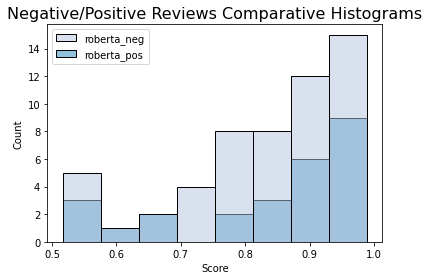

In [110]:
#fig, ax = plt.subplots(2, 1, figsize=(16, 5))
sns.histplot([results_df.query('roberta_neg >= 0.5')['roberta_neg'], 
              results_df.query('roberta_pos >= 0.5')['roberta_pos']],
              palette = 'PuBu')
plt.xlabel('Score')
plt.title('Negative/Positive Reviews Comparative Histograms', fontsize=16)
plt.show()

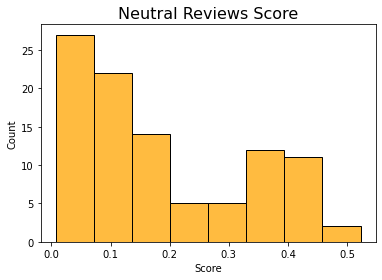

In [111]:
sns.histplot(results_df['roberta_neu'],  color = 'orange')
plt.title('Neutral Reviews Score', fontsize=16)
plt.xlabel('Score')
plt.show()